In [4]:
#Imports and utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from numpy import zeros, ones 
import numpy as np
from numpy.random import randn, randint
import tensorflow as tf
from matplotlib import pyplot as plt
from model.dcgan_cifar import discriminator_, generator_, dcgan_
from utils.dataset_utils import return_cifar10 
from utils.model_utils import true_samples_generator, fake_samples_generator, make_latent_samples
from utils.visualizers_utils import show_generated_images, performance_summarizer
from tqdm.notebook import tqdm
from utils.visualizers_utils import show_gan_losses
import imageio
from glob import glob
import re
from utils.visualizers_utils import generate_video 
from utils.image_utils import preprocess_image, scaleback_image, image_loader

Number of images in the train set:  202599
shape of each image is : (218, 178, 3)
********************
Original Images
********************


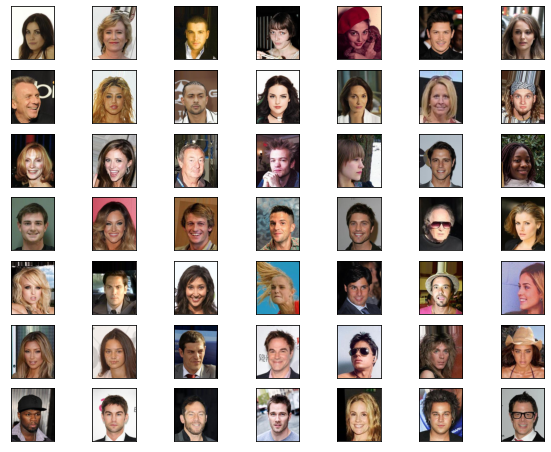

********************
After cropping & Reshaping
********************


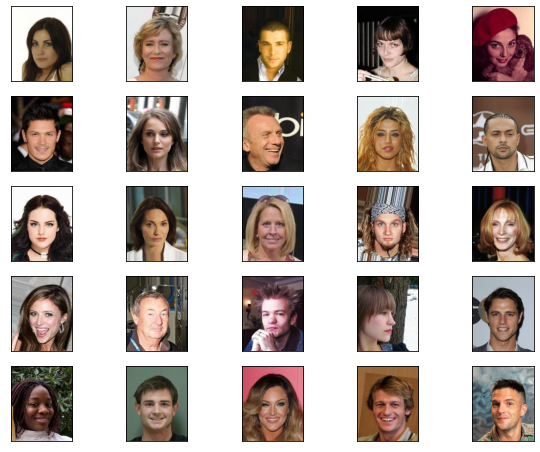

shape after cropping:  (218, 178, 3)


In [5]:
# Load CelebA dataset and displaying

X_train = np.array(glob('data/celeba_dataset/img_align_celeba/*.jpg'))
print("Number of images in the train set: ", X_train.shape[0])
print("shape of each image is :", plt.imread(X_train[0]).shape)

# To display images from the dataset
print('*'*20)
print("Original Images")
print('*'*20)
plt.figure(figsize=(10, 8))
for i in range(7*7):
    image = plt.imread(X_train[i])
    plt.subplot(7, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

plt.show()

print('*'*20)
print("After cropping & Reshaping")
print('*'*20)

# To display images from the dataset after cropping and reshaping
plt.figure(figsize=(10, 8))
for i in range(25):
    image = image_loader(X_train[i], resize_to=(32, 32))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
plt.show()
print("shape after cropping: ", image.shape)

In [6]:
# Function to train the generator and discriminator

def train(generator, discriminator, dcgan, data, samplesize, epochs=200, batch_size=128, model_name=None):
    print(f' Training {model_name} ......')
    num_batches = int(data.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    discriminator_losses = []
    generator_losses = [] 
    # manually enumerate epochs
    for epoch in tqdm(range(epochs)):
        generator_loss_epoch = 0 
        discriminator_loss_epoch = 0 

        # enumerate batches over the training set
        for batch in tqdm(range(num_batches)):
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size] #gets the file names 
            X_batch_real = np.array([(image_loader(file_, resize_to=(32,32))) for file_ in X_batch]) #get the images in the np format 
            
            X_batch_real =  X_batch_real.astype('float32')
            X_batch_real = (X_batch_real-127.5)/127.5
    
            # get randomly selected 'real' samples
            X_real, y_real = true_samples_generator(X_batch_real, half_batch)
            # update discriminator model weights
            discriminator_real_loss, _ = discriminator.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = fake_samples_generator(half_batch, samplesize, generator)
            # update discriminator model weights
            discriminator_fake_loss, _ = discriminator.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = make_latent_samples( samplesize, batch_size)
            # create inverted labels for the fake samples
            y_gan = np.ones((batch_size, 1))
            # update the generator via the discriminator's error
            generator_loss = dcgan.train_on_batch(X_gan, y_gan)

            #update the losses
            discriminator_loss_epoch += (discriminator_real_loss + discriminator_fake_loss)
            generator_loss_epoch += (generator_loss)

            # summarize loss on this batch
            if batch % 100 == 0:
                print(f' Epoch: {epoch + 1}, Batch: {batch + 1} of {num_batches}')
                print(f' Discriminator real loss: {discriminator_real_loss}, Discriminator Fake loss: {discriminator_fake_loss}, Generator loss: {generator_loss}')

        discriminator_losses.append(discriminator_loss_epoch)
        generator_losses.append(generator_loss_epoch)
        performance_summarizer(epoch, generator, discriminator, X_batch_real, samplesize, model_name=model_name)
    show_gan_losses(generator_losses, discriminator_losses, save_to= f'results/{model_name}/')
    print("Done with training the model ......")
    return generator

In [13]:
%%time
# size of the latent space
samplesize = 100


# create the discriminator
discriminator = discriminator_(in_shape=(32,32,3), 
                               d_lr=0.0002,
                               d_beta=0.5)
# create the generator
generator = generator_(samplesize)
# create the gan
dcgan = dcgan_(generator, discriminator)

# train model
trained_generator = train(generator, discriminator, dcgan, X_train, samplesize, epochs=10, batch_size=16, model_name="DCGAN_CELEBA_NOBN_")

 Training DCGAN_CELEBA_NOBN_ ......


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12662 [00:00<?, ?it/s]

 Epoch: 1, Batch: 1 of 12662
 Discriminator real loss: 0.6640465259552002, Discriminator Fake loss: 0.6963495016098022, Generator loss: 0.6907880902290344


KeyboardInterrupt: 

In [14]:
# To generate video from the trained model outputs 

# image_list =sorted(glob.glob('results/dcgan_cifar/eval_*'), key=lambda x:float(re.findall("(\d+)",x)[0]))
generate_video("DCGAN_CELEBA_NOBN")
# imageio.mimwrite('animated_from_images.gif', image_list)
# image_list

Epoch evolutions video saved as results/DCGAN_CELEBA_NOBN/outputs_evolution.avi


## DCGAN - No Batch Norm, More Epochs

 Training DCGAN_CELEBA_NOBN_40Epochs ......


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 1, Batch: 1 of 1582
 Discriminator real loss: 0.7091373801231384, Discriminator Fake loss: 0.695473313331604, Generator loss: 0.6915391087532043
 Epoch: 1, Batch: 101 of 1582
 Discriminator real loss: 0.2308654636144638, Discriminator Fake loss: 0.05586591735482216, Generator loss: 3.7129197120666504
 Epoch: 1, Batch: 201 of 1582
 Discriminator real loss: 0.6608294248580933, Discriminator Fake loss: 0.5871970653533936, Generator loss: 3.197719097137451
 Epoch: 1, Batch: 301 of 1582
 Discriminator real loss: 0.2806773781776428, Discriminator Fake loss: 0.2497987002134323, Generator loss: 2.578486204147339
 Epoch: 1, Batch: 401 of 1582
 Discriminator real loss: 0.6508147716522217, Discriminator Fake loss: 0.2818572521209717, Generator loss: 1.7936458587646484
 Epoch: 1, Batch: 501 of 1582
 Discriminator real loss: 0.7487821578979492, Discriminator Fake loss: 0.3733730912208557, Generator loss: 1.76462721824646
 Epoch: 1, Batch: 601 of 1582
 Discriminator real loss: 0.790190100669

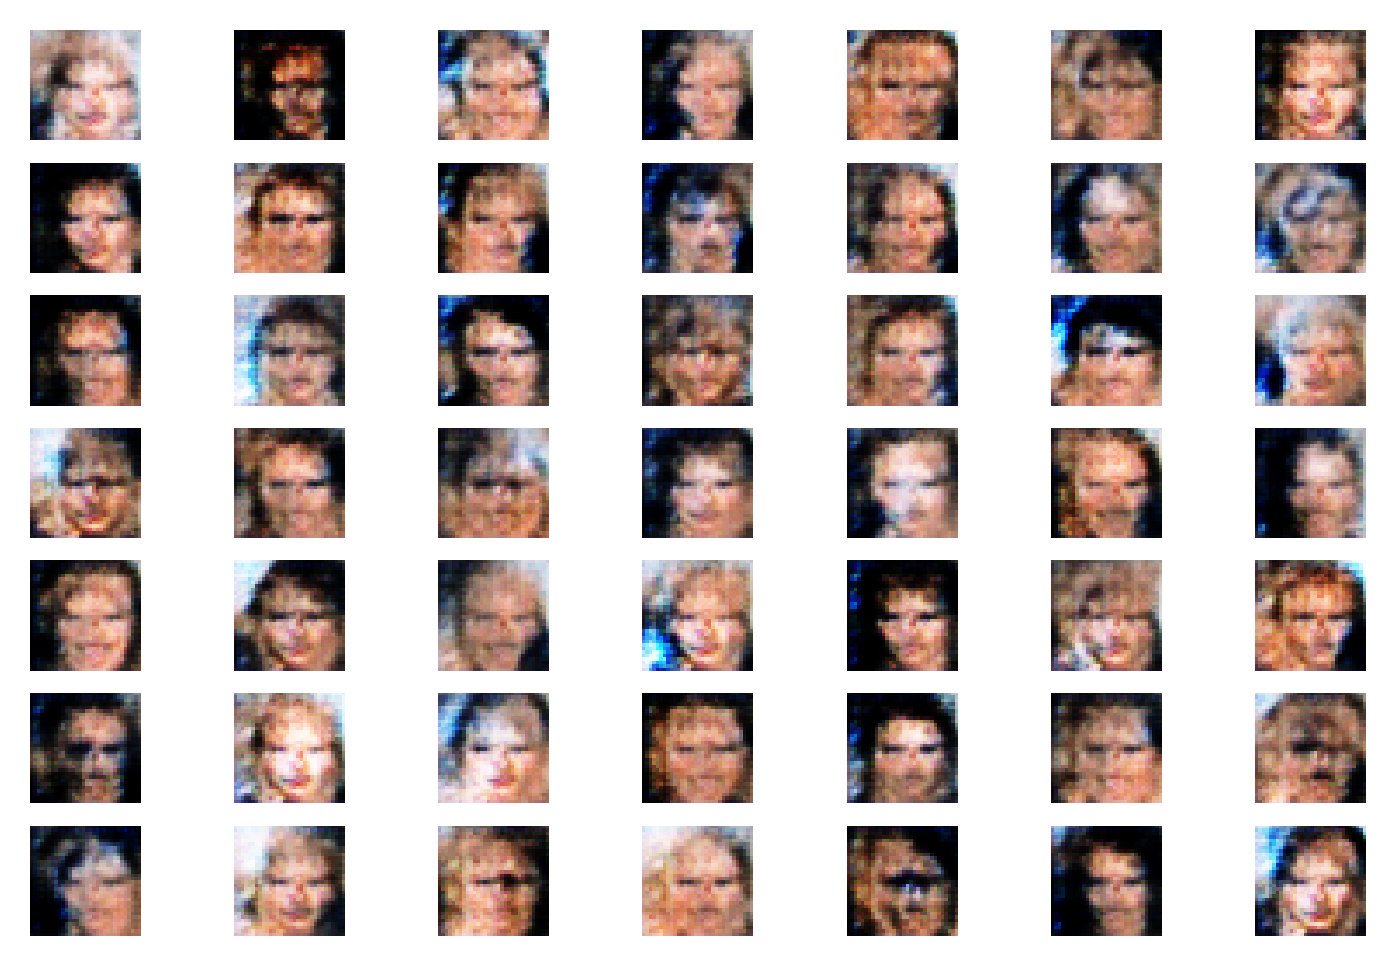

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 2, Batch: 1 of 1582
 Discriminator real loss: 0.6539233922958374, Discriminator Fake loss: 0.6385740041732788, Generator loss: 1.20782470703125
 Epoch: 2, Batch: 101 of 1582
 Discriminator real loss: 0.40708956122398376, Discriminator Fake loss: 0.5422073602676392, Generator loss: 1.1453516483306885
 Epoch: 2, Batch: 201 of 1582
 Discriminator real loss: 0.6183027029037476, Discriminator Fake loss: 0.7536409497261047, Generator loss: 1.201045274734497
 Epoch: 2, Batch: 301 of 1582
 Discriminator real loss: 0.6065794825553894, Discriminator Fake loss: 0.5597410202026367, Generator loss: 1.0979185104370117
 Epoch: 2, Batch: 401 of 1582
 Discriminator real loss: 0.4710979759693146, Discriminator Fake loss: 0.6134155988693237, Generator loss: 1.1454073190689087
 Epoch: 2, Batch: 501 of 1582
 Discriminator real loss: 0.6103036403656006, Discriminator Fake loss: 0.5632150769233704, Generator loss: 1.186524748802185
 Epoch: 2, Batch: 601 of 1582
 Discriminator real loss: 0.61821961402

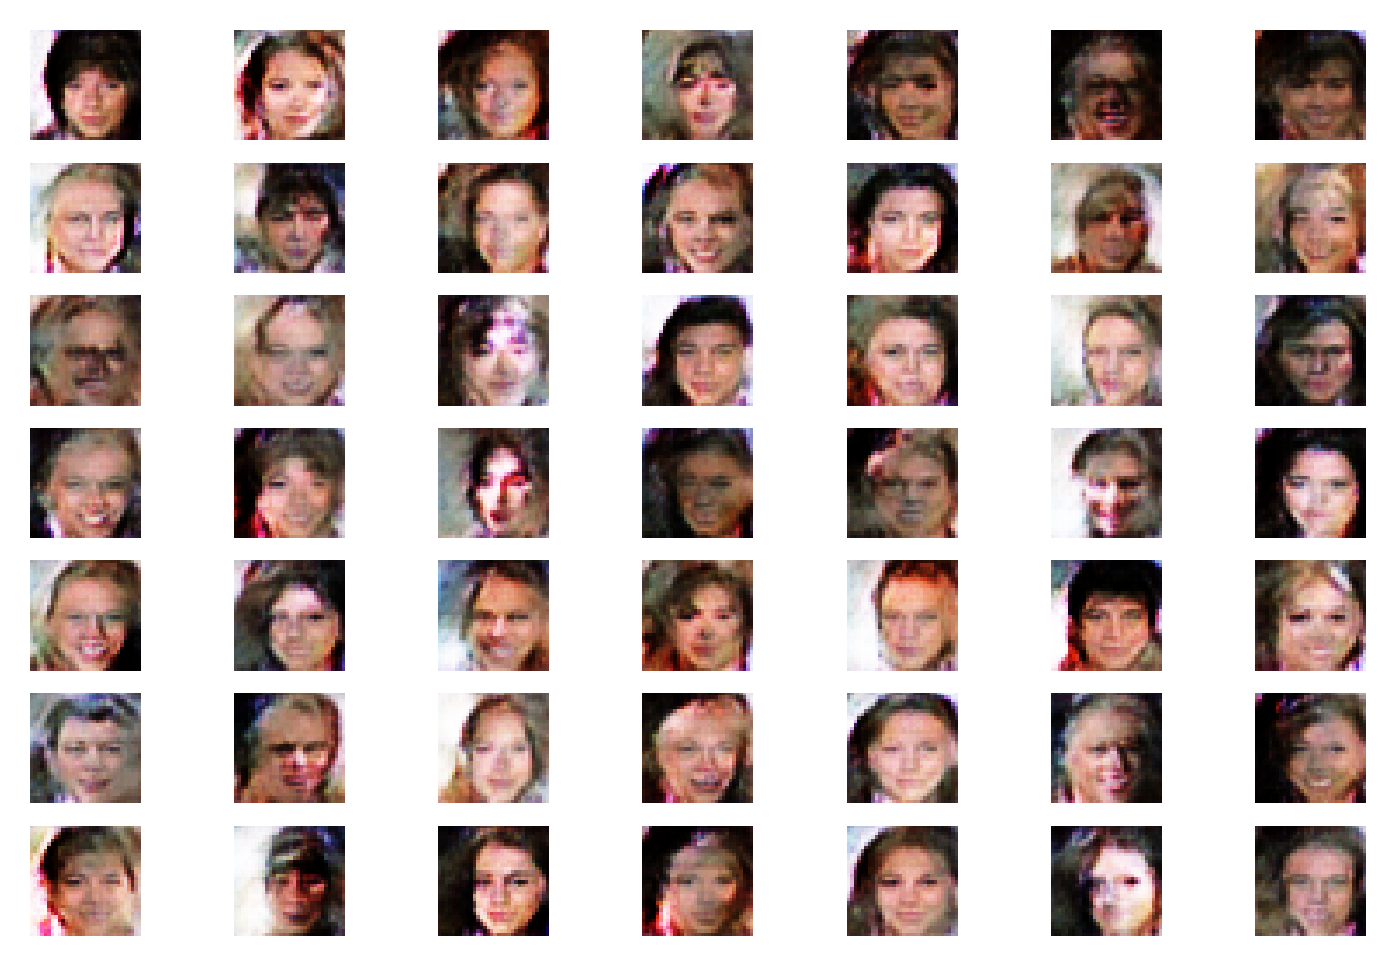

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 3, Batch: 1 of 1582
 Discriminator real loss: 0.6020542979240417, Discriminator Fake loss: 0.6379391551017761, Generator loss: 1.0066092014312744
 Epoch: 3, Batch: 101 of 1582
 Discriminator real loss: 0.567733883857727, Discriminator Fake loss: 0.5896546840667725, Generator loss: 0.9769015908241272
 Epoch: 3, Batch: 201 of 1582
 Discriminator real loss: 0.6329991221427917, Discriminator Fake loss: 0.6145925521850586, Generator loss: 0.9102778434753418
 Epoch: 3, Batch: 301 of 1582
 Discriminator real loss: 0.6276413202285767, Discriminator Fake loss: 0.49567481875419617, Generator loss: 1.080495834350586
 Epoch: 3, Batch: 401 of 1582
 Discriminator real loss: 0.6071953773498535, Discriminator Fake loss: 0.6590964794158936, Generator loss: 0.9728057384490967
 Epoch: 3, Batch: 501 of 1582
 Discriminator real loss: 0.6422579288482666, Discriminator Fake loss: 0.655061662197113, Generator loss: 0.9473410844802856
 Epoch: 3, Batch: 601 of 1582
 Discriminator real loss: 0.7066601514

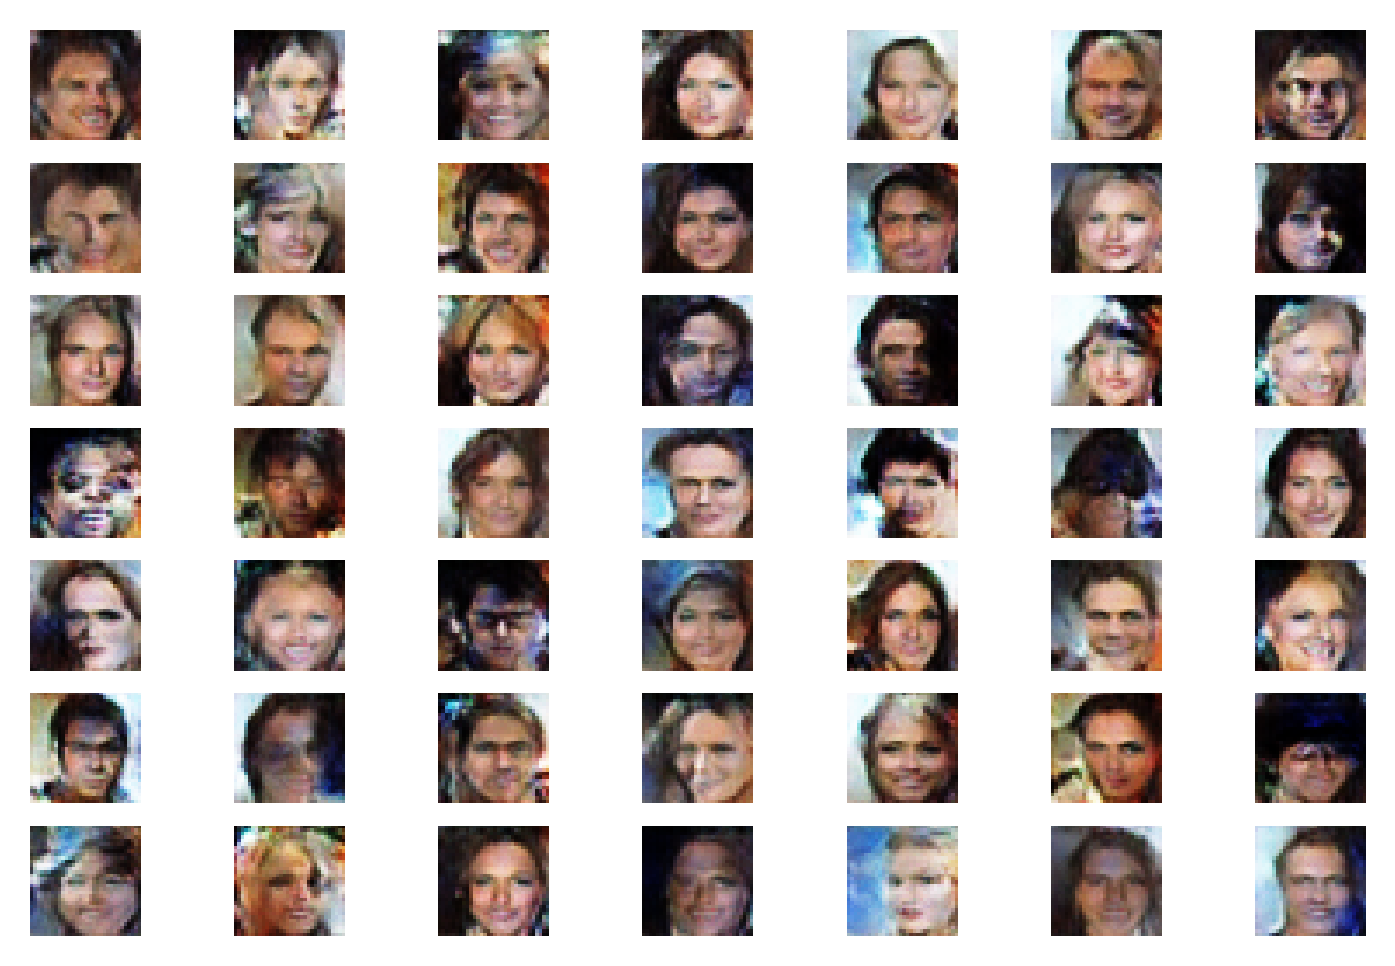

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 4, Batch: 1 of 1582
 Discriminator real loss: 0.6537166237831116, Discriminator Fake loss: 0.6497693061828613, Generator loss: 0.9017977118492126
 Epoch: 4, Batch: 101 of 1582
 Discriminator real loss: 0.6402661800384521, Discriminator Fake loss: 0.6440449953079224, Generator loss: 0.852163553237915
 Epoch: 4, Batch: 201 of 1582
 Discriminator real loss: 0.6393932104110718, Discriminator Fake loss: 0.6105266213417053, Generator loss: 0.9030469655990601
 Epoch: 4, Batch: 301 of 1582
 Discriminator real loss: 0.7109061479568481, Discriminator Fake loss: 0.62775719165802, Generator loss: 0.8760797381401062
 Epoch: 4, Batch: 401 of 1582
 Discriminator real loss: 0.6601200699806213, Discriminator Fake loss: 0.7099153995513916, Generator loss: 0.8286730647087097
 Epoch: 4, Batch: 501 of 1582
 Discriminator real loss: 0.7060264348983765, Discriminator Fake loss: 0.6835336685180664, Generator loss: 0.878315806388855
 Epoch: 4, Batch: 601 of 1582
 Discriminator real loss: 0.664054691791

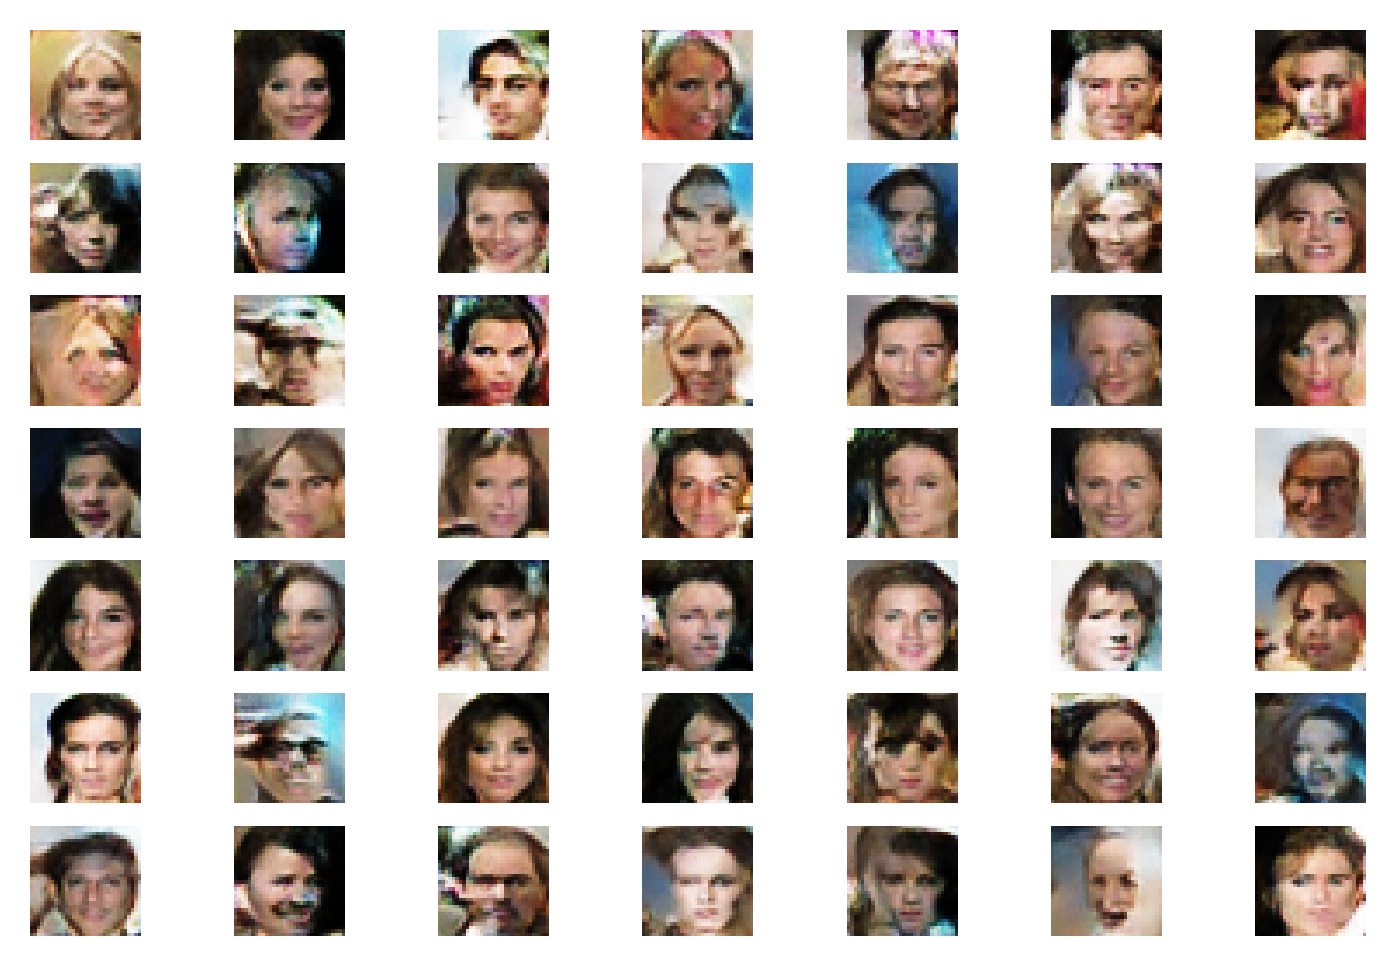

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 5, Batch: 1 of 1582
 Discriminator real loss: 0.6595204472541809, Discriminator Fake loss: 0.6853384971618652, Generator loss: 0.812294602394104
 Epoch: 5, Batch: 101 of 1582
 Discriminator real loss: 0.7229530811309814, Discriminator Fake loss: 0.6238355040550232, Generator loss: 0.8238399624824524
 Epoch: 5, Batch: 201 of 1582
 Discriminator real loss: 0.7140234708786011, Discriminator Fake loss: 0.6653782725334167, Generator loss: 0.821313202381134
 Epoch: 5, Batch: 301 of 1582
 Discriminator real loss: 0.5990450978279114, Discriminator Fake loss: 0.7000354528427124, Generator loss: 0.7741130590438843
 Epoch: 5, Batch: 401 of 1582
 Discriminator real loss: 0.6963557004928589, Discriminator Fake loss: 0.6715050935745239, Generator loss: 0.8146206736564636
 Epoch: 5, Batch: 501 of 1582
 Discriminator real loss: 0.7034014463424683, Discriminator Fake loss: 0.7030059099197388, Generator loss: 0.8032838106155396
 Epoch: 5, Batch: 601 of 1582
 Discriminator real loss: 0.7353205680

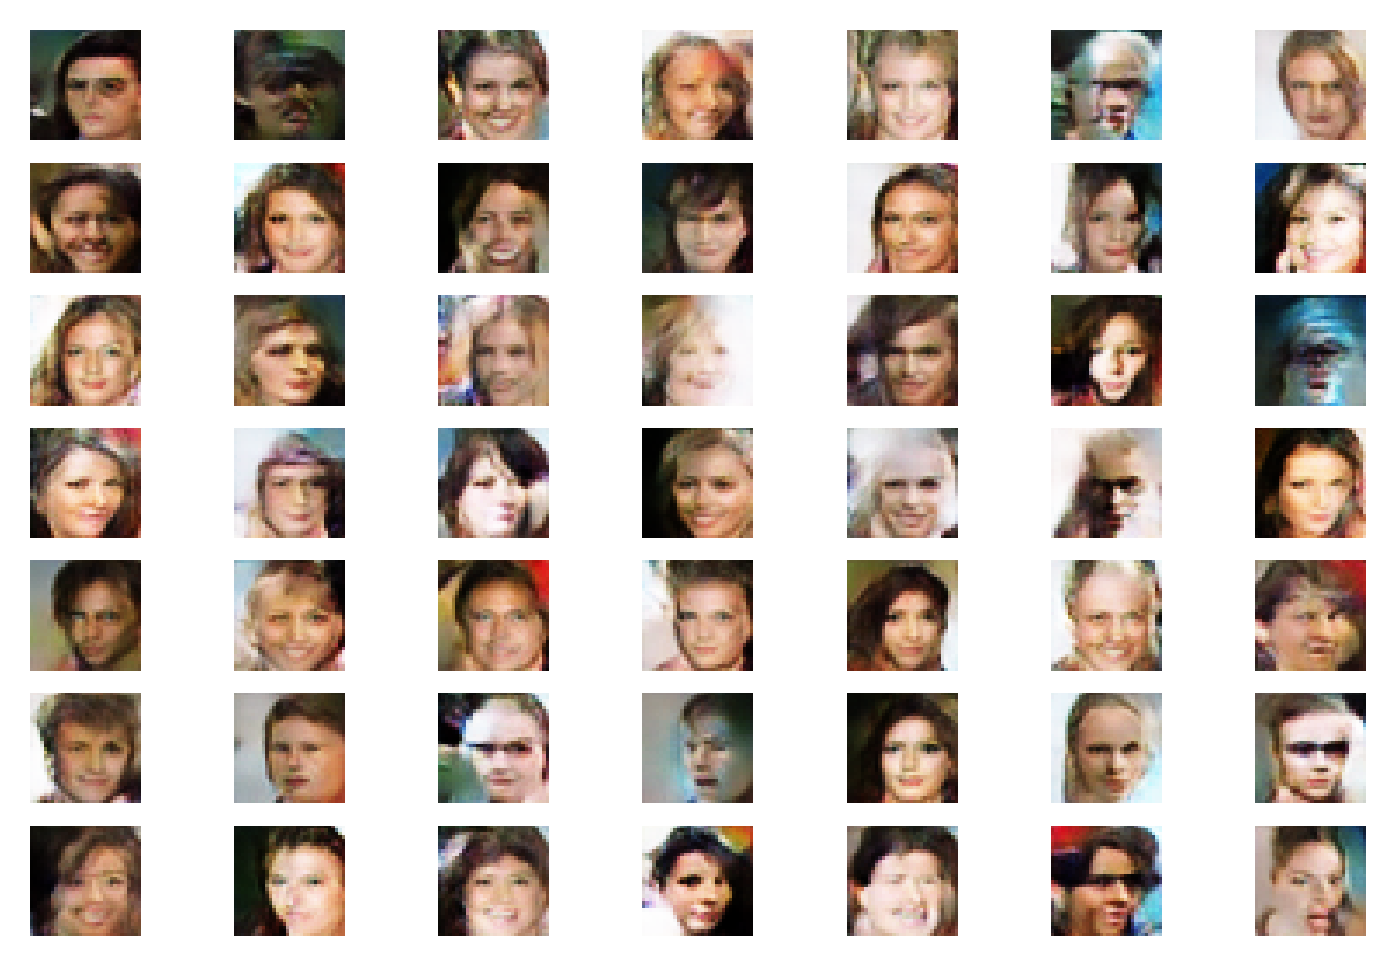

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 6, Batch: 1 of 1582
 Discriminator real loss: 0.6637625098228455, Discriminator Fake loss: 0.6765937805175781, Generator loss: 0.7693256735801697
 Epoch: 6, Batch: 101 of 1582
 Discriminator real loss: 0.701403796672821, Discriminator Fake loss: 0.6681327819824219, Generator loss: 0.8269240856170654
 Epoch: 6, Batch: 201 of 1582
 Discriminator real loss: 0.6605230569839478, Discriminator Fake loss: 0.6863397359848022, Generator loss: 0.752299427986145
 Epoch: 6, Batch: 301 of 1582
 Discriminator real loss: 0.6915591955184937, Discriminator Fake loss: 0.6957788467407227, Generator loss: 0.7789095640182495
 Epoch: 6, Batch: 401 of 1582
 Discriminator real loss: 0.6584908962249756, Discriminator Fake loss: 0.6676480770111084, Generator loss: 0.766116738319397
 Epoch: 6, Batch: 501 of 1582
 Discriminator real loss: 0.7038154602050781, Discriminator Fake loss: 0.6559422612190247, Generator loss: 0.7717365026473999
 Epoch: 6, Batch: 601 of 1582
 Discriminator real loss: 0.72491741180

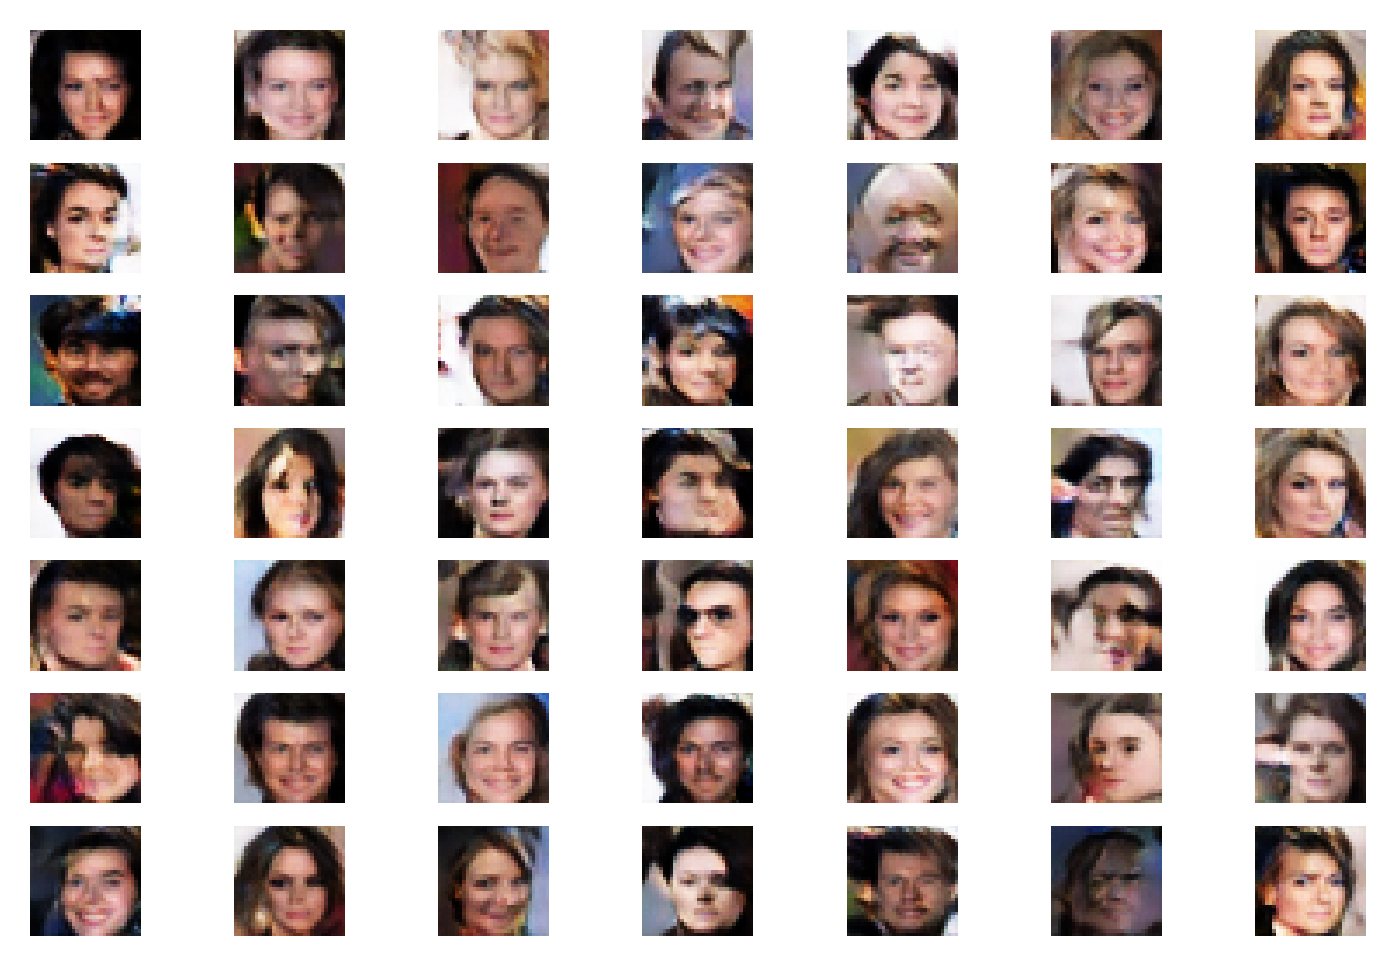

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 7, Batch: 1 of 1582
 Discriminator real loss: 0.686290979385376, Discriminator Fake loss: 0.7185019254684448, Generator loss: 0.7472490072250366
 Epoch: 7, Batch: 101 of 1582
 Discriminator real loss: 0.6577171087265015, Discriminator Fake loss: 0.6544716358184814, Generator loss: 0.788683295249939
 Epoch: 7, Batch: 201 of 1582
 Discriminator real loss: 0.6870067715644836, Discriminator Fake loss: 0.6725003719329834, Generator loss: 0.7647249102592468
 Epoch: 7, Batch: 301 of 1582
 Discriminator real loss: 0.6760514974594116, Discriminator Fake loss: 0.710573136806488, Generator loss: 0.7565351128578186
 Epoch: 7, Batch: 401 of 1582
 Discriminator real loss: 0.6674443483352661, Discriminator Fake loss: 0.6692198514938354, Generator loss: 0.7721593379974365
 Epoch: 7, Batch: 501 of 1582
 Discriminator real loss: 0.7080650925636292, Discriminator Fake loss: 0.6983110904693604, Generator loss: 0.7650439143180847
 Epoch: 7, Batch: 601 of 1582
 Discriminator real loss: 0.70031940937

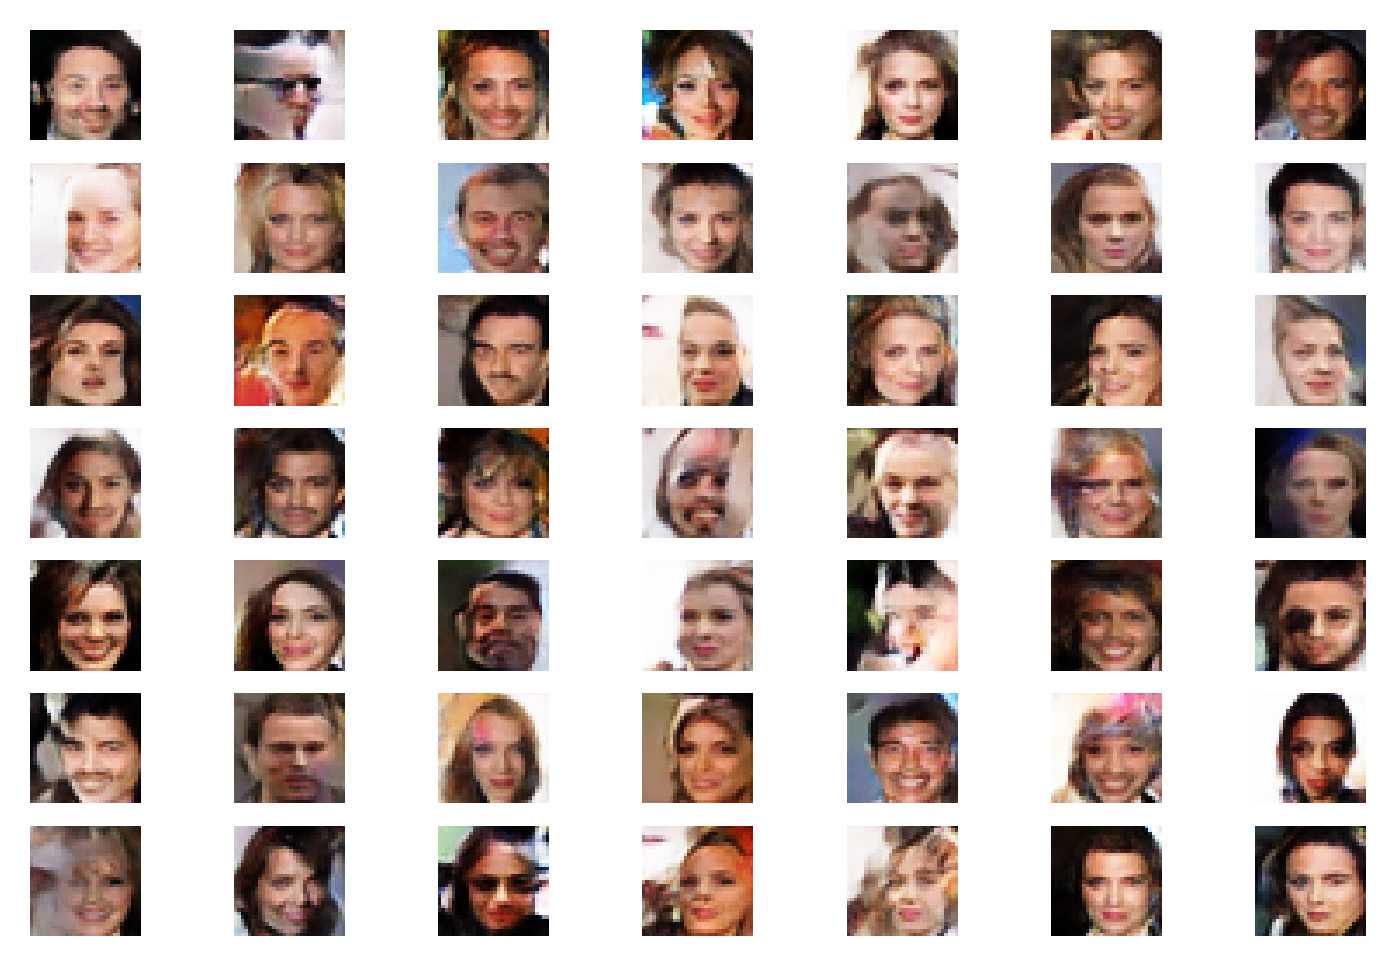

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 8, Batch: 1 of 1582
 Discriminator real loss: 0.6656273007392883, Discriminator Fake loss: 0.6827579736709595, Generator loss: 0.7582236528396606
 Epoch: 8, Batch: 101 of 1582
 Discriminator real loss: 0.6781438589096069, Discriminator Fake loss: 0.7042911052703857, Generator loss: 0.7622236013412476
 Epoch: 8, Batch: 201 of 1582
 Discriminator real loss: 0.7184160947799683, Discriminator Fake loss: 0.6733525991439819, Generator loss: 0.7508162260055542
 Epoch: 8, Batch: 301 of 1582
 Discriminator real loss: 0.6942703127861023, Discriminator Fake loss: 0.675798237323761, Generator loss: 0.7303143739700317
 Epoch: 8, Batch: 401 of 1582
 Discriminator real loss: 0.7009992599487305, Discriminator Fake loss: 0.6665198802947998, Generator loss: 0.7330091595649719
 Epoch: 8, Batch: 501 of 1582
 Discriminator real loss: 0.6919853687286377, Discriminator Fake loss: 0.6780257225036621, Generator loss: 0.7389249205589294
 Epoch: 8, Batch: 601 of 1582
 Discriminator real loss: 0.719275176

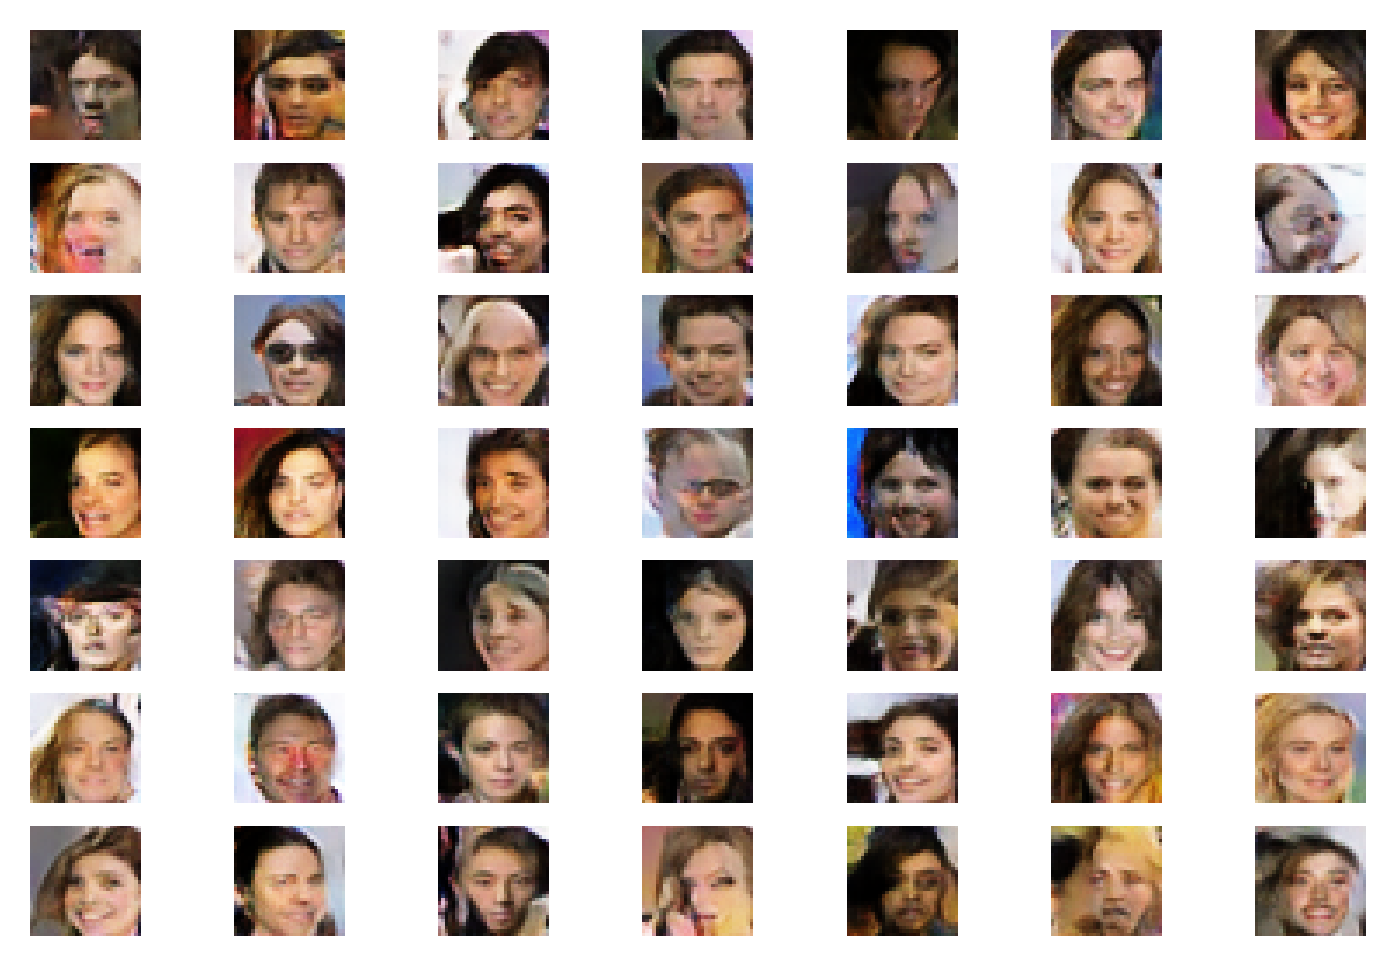

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 9, Batch: 1 of 1582
 Discriminator real loss: 0.6747156977653503, Discriminator Fake loss: 0.6828299760818481, Generator loss: 0.7280707359313965
 Epoch: 9, Batch: 101 of 1582
 Discriminator real loss: 0.7044222950935364, Discriminator Fake loss: 0.6770943403244019, Generator loss: 0.7472405433654785
 Epoch: 9, Batch: 201 of 1582
 Discriminator real loss: 0.7124736309051514, Discriminator Fake loss: 0.7021888494491577, Generator loss: 0.7285550236701965
 Epoch: 9, Batch: 301 of 1582
 Discriminator real loss: 0.6951475143432617, Discriminator Fake loss: 0.6971732378005981, Generator loss: 0.7234506011009216
 Epoch: 9, Batch: 401 of 1582
 Discriminator real loss: 0.7264255881309509, Discriminator Fake loss: 0.6756483316421509, Generator loss: 0.7623714804649353
 Epoch: 9, Batch: 501 of 1582
 Discriminator real loss: 0.691818356513977, Discriminator Fake loss: 0.6842012405395508, Generator loss: 0.750555694103241
 Epoch: 9, Batch: 601 of 1582
 Discriminator real loss: 0.7238600254

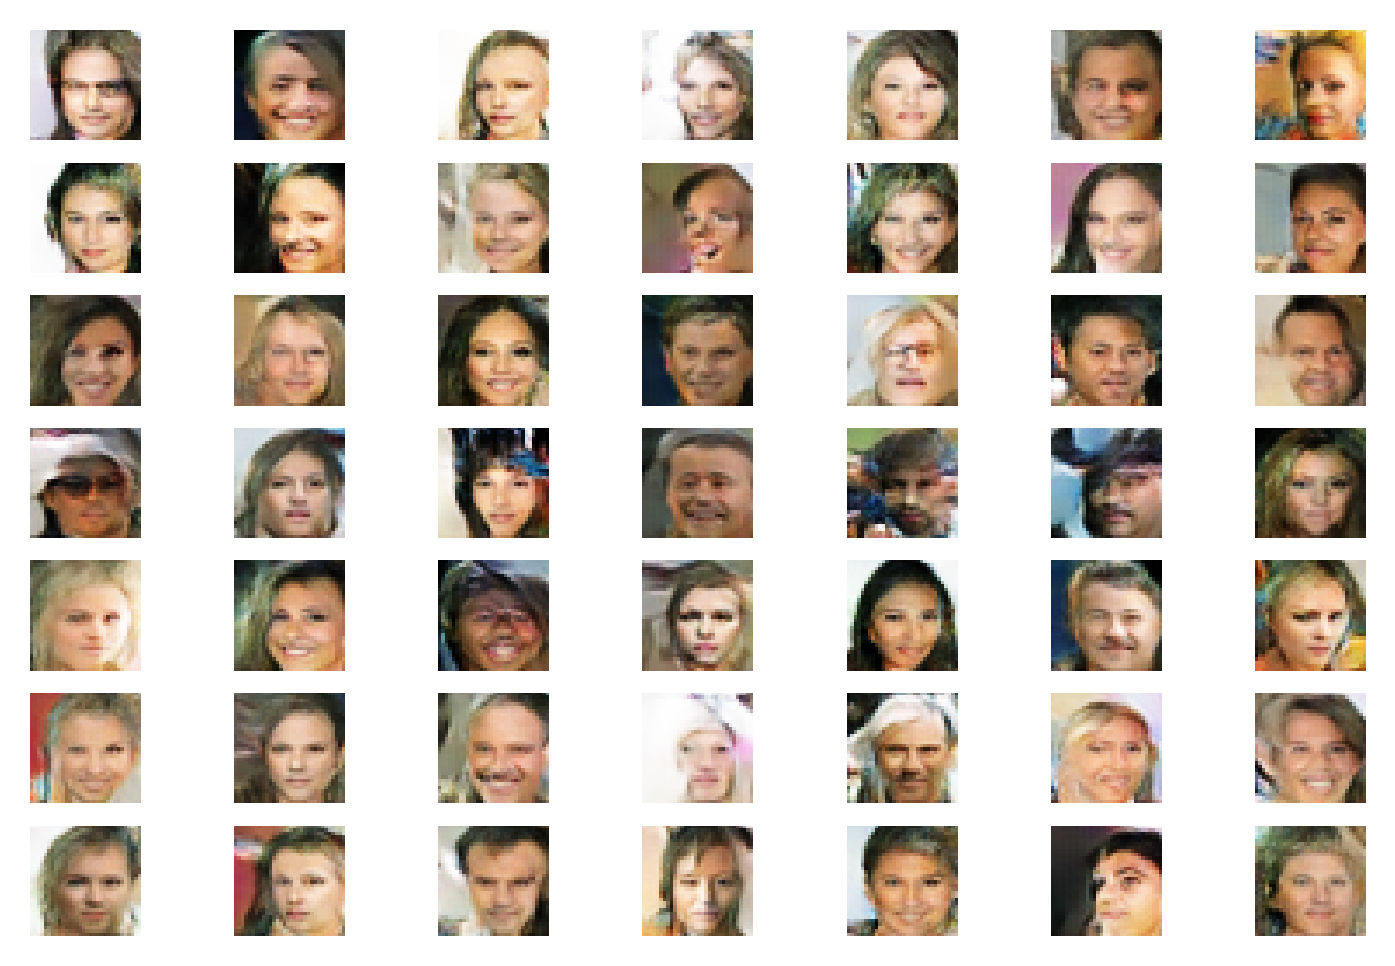

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 10, Batch: 1 of 1582
 Discriminator real loss: 0.6772613525390625, Discriminator Fake loss: 0.6956489086151123, Generator loss: 0.733609676361084
 Epoch: 10, Batch: 101 of 1582
 Discriminator real loss: 0.7056260108947754, Discriminator Fake loss: 0.723302960395813, Generator loss: 0.7378600835800171
 Epoch: 10, Batch: 201 of 1582
 Discriminator real loss: 0.7022780776023865, Discriminator Fake loss: 0.716965913772583, Generator loss: 0.7354221940040588
 Epoch: 10, Batch: 301 of 1582
 Discriminator real loss: 0.6872644424438477, Discriminator Fake loss: 0.6708057522773743, Generator loss: 0.7314389944076538
 Epoch: 10, Batch: 401 of 1582
 Discriminator real loss: 0.7240937352180481, Discriminator Fake loss: 0.682045042514801, Generator loss: 0.7363150119781494
 Epoch: 10, Batch: 501 of 1582
 Discriminator real loss: 0.6977101564407349, Discriminator Fake loss: 0.6783718466758728, Generator loss: 0.7393304109573364
 Epoch: 10, Batch: 601 of 1582
 Discriminator real loss: 0.69631

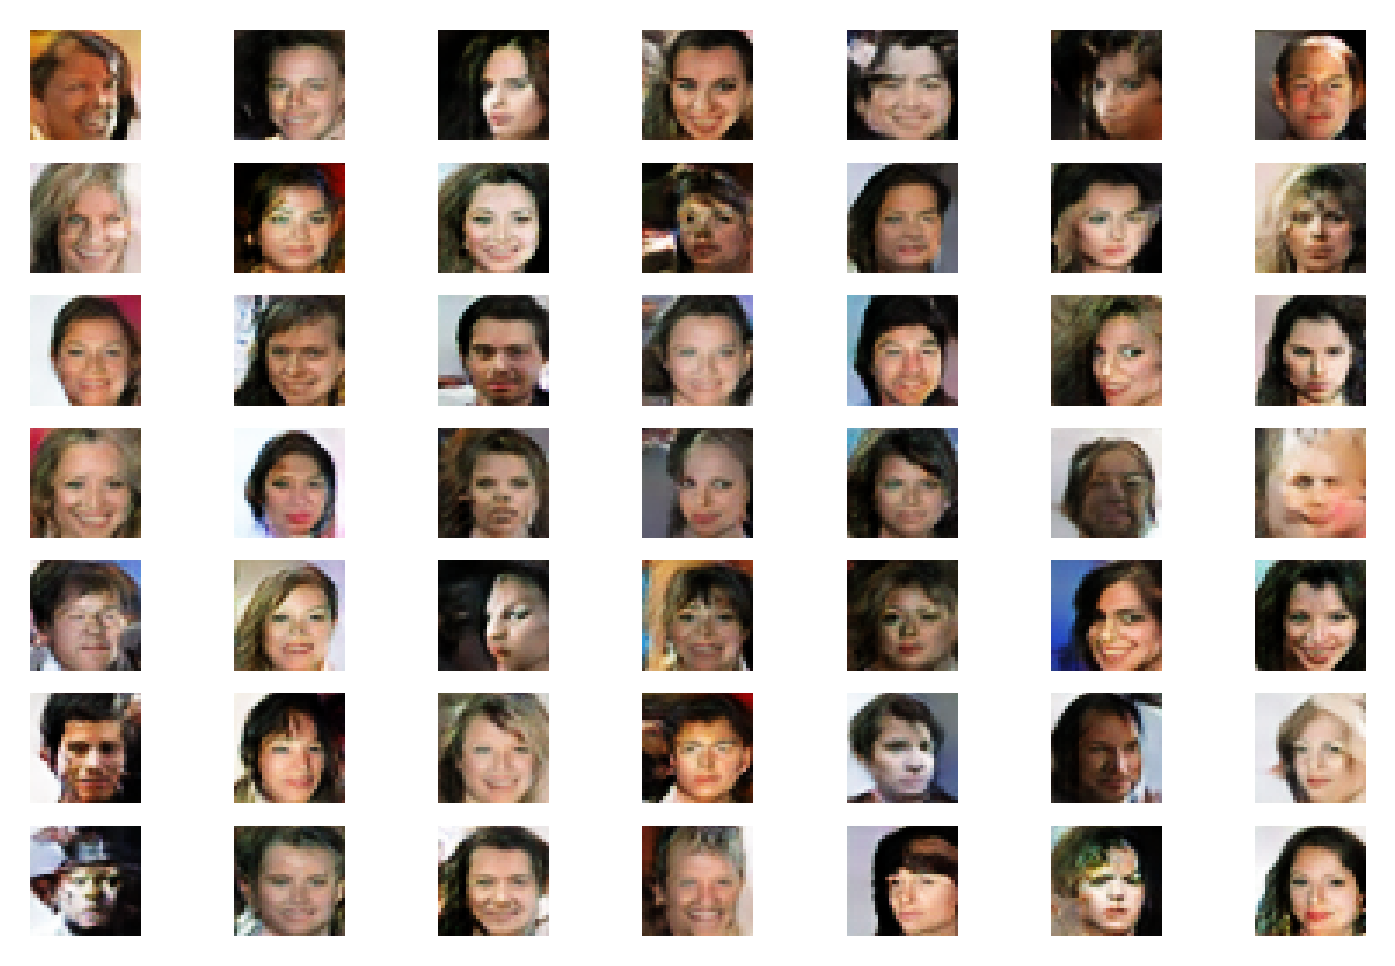

INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/generator/assets
INFO:tensorflow:Assets written to: trained_models/DCGAN_CELEBA_NOBN_40Epochs/discriminator/assets


  0%|          | 0/1582 [00:00<?, ?it/s]

 Epoch: 11, Batch: 1 of 1582
 Discriminator real loss: 0.6911834478378296, Discriminator Fake loss: 0.6780874729156494, Generator loss: 0.7097314596176147
 Epoch: 11, Batch: 101 of 1582
 Discriminator real loss: 0.6865264773368835, Discriminator Fake loss: 0.7176792025566101, Generator loss: 0.7628624439239502
 Epoch: 11, Batch: 201 of 1582
 Discriminator real loss: 0.7078487277030945, Discriminator Fake loss: 0.6990273594856262, Generator loss: 0.7333347201347351
 Epoch: 11, Batch: 301 of 1582
 Discriminator real loss: 0.7127983570098877, Discriminator Fake loss: 0.6583482027053833, Generator loss: 0.7631784081459045
 Epoch: 11, Batch: 401 of 1582
 Discriminator real loss: 0.6879273653030396, Discriminator Fake loss: 0.7035328149795532, Generator loss: 0.7340219616889954
 Epoch: 11, Batch: 501 of 1582
 Discriminator real loss: 0.6934119462966919, Discriminator Fake loss: 0.6871851682662964, Generator loss: 0.7380563020706177
 Epoch: 11, Batch: 601 of 1582
 Discriminator real loss: 0.6

In [ ]:
%%time

# size of the latent space
samplesize = 100

# create the discriminator
discriminator = discriminator_(in_shape=(32,32,3), 
                               d_lr=0.0002,
                               d_beta=0.5)

# create the generator
generator = generator_(samplesize)

# create the gan
dcgan = dcgan_(generator, discriminator)

# train model
trained_generator = train(generator, discriminator, dcgan, X_train, samplesize, epochs=40, batch_size=128, model_name="DCGAN_CELEBA_NOBN_40Epochs")

In [4]:
generate_video("dcgan_cifar_withbatchnorm")

Epoch evolutions video saved as results/dcgan_cifar_withbatchnorm/outputs_evolution.avi
